A. Install package, modul and Preprocessing data

In [83]:
!pip install arch
!pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [65]:
sp_index = pd.read_csv('D:/STUDY/STUDY/PYTHON/Grach model/SP500.csv')
sp_index.head()

,Date,Close
0,1/4/2010,1132.99
1,1/5/2010,1136.52
2,1/6/2010,1137.14
3,1/7/2010,1141.69
4,1/8/2010,1144.98


Recall in GARCH(1,1), since beta is the coefficient of lag-1 variance, if the alpha is fixed, the larger the beta , the longer the duration of the impact. In other words, high or low volatility periods tend to persist. Pay attention to the plotted results and see whether you can verify the beta impact.

In [66]:
# Calculate daily returns as percentage price changes

sp_index['Return'] = pd.Series(np.log(sp_index['Close'] / sp_index['Close'].shift(1)))
sp_index = sp_index.dropna()
sp_index

,Date,Close,Return
1,1/5/2010,1136.52,0.003111
2,1/6/2010,1137.14,0.000545
3,1/7/2010,1141.69,0.003993
4,1/8/2010,1144.98,0.002878
5,1/11/2010,1146.98,0.001745
...,...,...,...
3347,4/21/2023,4133.52,0.000903
3348,4/24/2023,4137.04,0.000851
3349,4/25/2023,4071.63,-0.015937
3350,4/26/2023,4055.99,-0.003849


In [67]:
sp_index.dtypes

Date       object
Close     float64
Return    float64
dtype: object

In [68]:
# Change type of Date from object to datetime
sp_index['Date'] = pd.to_datetime(sp_index['Date'])
sp_index.dtypes

Date      datetime64[ns]
Close            float64
Return           float64
dtype: object

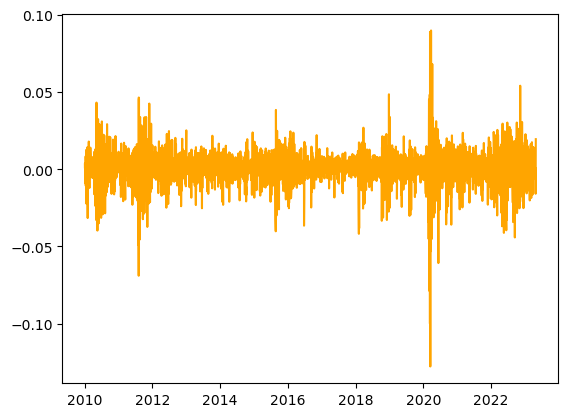

In [69]:
# Plot the price returns
plt.plot(sp_index['Date'],sp_index['Return'], color = 'orange')
plt.show()

B. Split data into train and test `

In [85]:
from sklearn.model_selection import train_test_split
train_index, test_index = train_test_split(sp_index,test_size = 0.2, shuffle=False)

In [88]:
# Calculate daily std of returns (historical)
std_daily = train_index['Return'].std()
var_daily = train_index['Return'].var()
print('Daily volatility: ', '{:.3f}%'.format(std_daily))
print('Daily variance: ', '{:.3f}%'.format(var_daily))

# Convert daily volatility to monthly volatility (historical)
std_monthly = math.sqrt(21) * std_daily
print ('Monthly volatility: ', '{:.3f}%'.format(std_monthly))

# Convert daily volatility to annaul volatility (historical)
std_annual = math.sqrt(252) * std_daily
print ('Annual volatility: ', '{:.3f}%'.format(std_annual))

Daily volatility:  0.011%
Daily variance:  0.000%
Monthly volatility:  0.051%
Annual volatility:  0.175%


Simulating a GARCH model involves generating artificial data that mimics the behavior of a GARCH time series. To simulate a GARCH model, you need to first estimate the model parameters using historical data. 

In [79]:
# Calculate the initial value of omega
omega_ini = 0.0001 * var_daily
print(omega)

# Calculate the initial value of alpha
alpha_ini = 0.5 * std_annual
print(alpha)

# Calculate the initial value of beta
beta_ini = 0.45 * std_annual
print(beta)

1.2597911706359647e-08
0.08908807089058882
0.08017926380152994


C. Fit GARCH(1,1) model with normal distribution and skewt t-distribution

In [72]:
from arch import arch_model

In [82]:
# Specify GARCH model assumptions
basic_gm = arch_model(sp_index['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 180,start_params=[alpha_ini, beta_ini, omega_ini])
# Display model fitting summary
print(gm_result.summary())

TypeError: fit() got an unexpected keyword argument 'start_params'

R-squared and adjusted R-squared are both zero, indicating that the mean model does not explain much of the variation in the data


C-1. Apply normal distribution assumption of the standardized residuals.

Returns = the mean returns + residuals, and residuals are a stochastic return shocks dependent on the size of the volatility. Therefore to model volatility, GARCH models require making distribution assumptions of both the residuals and the mean returns.

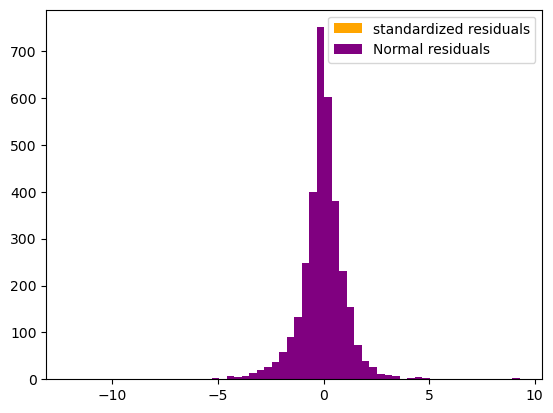

In [52]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.hist(gm_std_resid, bins = 60, 
         facecolor = 'orange', label = 'standardized residuals')
plt.hist(gm_resid, bins = 60, 
         facecolor = 'purple', label = 'Normal residuals')
plt.legend(loc = 'upper right')
plt.show()

=> It look like my standardized residuals have a normal distribution -> the model has captured the underlying patterns in the data.

C-2. Apply skewed Student's t-distribution assumption

Iteration:      1,   Func. Count:      8,   Neg. LLF: 31154.521627859758
Iteration:      2,   Func. Count:     21,   Neg. LLF: 19583.7982142002
Iteration:      3,   Func. Count:     32,   Neg. LLF: 186234.15210111073
Iteration:      4,   Func. Count:     40,   Neg. LLF: 7274.556050736161
Iteration:      5,   Func. Count:     48,   Neg. LLF: 4288.0506126736445
Iteration:      6,   Func. Count:     56,   Neg. LLF: 4484.3263935129
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4241.392724744923
Iteration:      8,   Func. Count:     71,   Neg. LLF: 5182.444808384344
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4242.252524225442
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4241.047281761241
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4241.042150378173
Iteration:     12,   Func. Count:    102,   Neg. LLF: 4241.041895820041
Iteration:     13,   Func. Count:    109,   Neg. LLF: 4241.041891206226
Iteration:     14,   Func. Count:    115,   Neg. LLF: 4241.04189

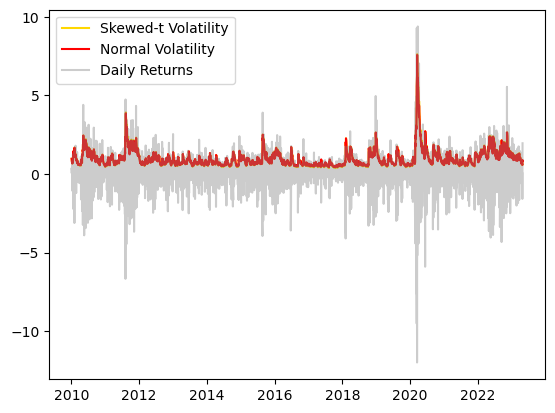

In [55]:
# Specify GARCH model assumptions
skewt_gm = arch_model(train_index['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')
# Fit the model
skewt_result = skewt_gm.fit()

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

# Plot model fitting results
plt.plot(train_index['Date'], skewt_vol, color = 'gold', label = 'Skewed-t Volatility')
plt.plot(train_index['Date'], gm_std, color = 'red', label = 'Normal Volatility')
plt.plot(train_index['Date'], train_index['Return'], color = 'grey', label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper left')
plt.show()

using the p-values to decide the necessity of model parameters, and define a parsimonious model without insignificant parameters.The null hypothesis is the parameter value is zero. If the p-value is larger than a given confidence level (5%), the null hypothesis cannot be rejected, meaning the parameter is not statistically significant, hence not necessary.

In [ ]:
# Print model fitting summary
print(gm_result.summary())

# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'p-value': gm_result.pvalues})

# Print out parameter stats
print(para_summary)

D. Forecast 

D1. Forecast 

In [ ]:
# Make 5-period ahead forecast 
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

"5-periods" refers to a forecast horizon of 5 time periods into the future. So, gm_forecast = gm_result.forecast(horizon = 5) generates a forecast of the variance of the SP500 returns for the next 5 time periods. The length of each time period would depend on the frequency of the data, which in your case would be daily since you are using daily close prices and returns. So, if each time period represents one day, then the 5-period horizon would be a forecast for the next 5 trading days.

E. Forecast with fixed rolling window

Iteration:      5,   Func. Count:     37,   Neg. LLF: 295.2837144395388
Optimization terminated successfully    (Exit mode 0)
            Current function value: 283.43346606427474
            Iterations: 8
            Function evaluations: 53
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     37,   Neg. LLF: 285.71766175212764
Optimization terminated successfully    (Exit mode 0)
            Current function value: 283.7167341886154
            Iterations: 8
            Function evaluations: 53
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     37,   Neg. LLF: 285.2951464831001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 284.21938061264854
            Iterations: 8
            Function evaluations: 53
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     37,   Neg. LLF: 286.41951225358673
Optimization terminated successfully    (Exit mode 0)
            Current function valu

Iteration:      5,   Func. Count:     32,   Neg. LLF: 269.4863344584978
Optimization terminated successfully    (Exit mode 0)
            Current function value: 268.74730951992365
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


TypeError: cannot do slice indexing on Int64Index with these indexers [2022-5-2] of type str

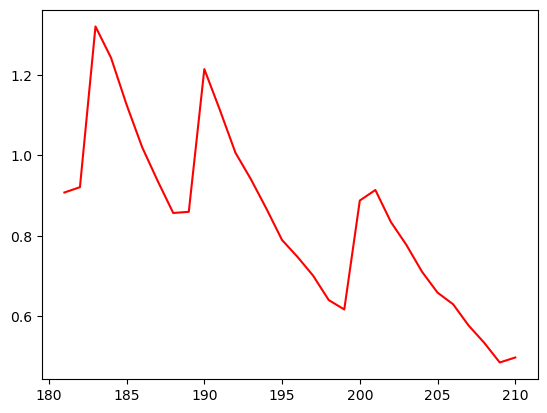

In [50]:
start_loc = 0
end_loc = 180
forecasts = {}
for i in range(30):
    # Determine window side for trainning(fitting) of fixed rolling window 
    redef_gm_result = basic_gm.fit(start_ob = start_loc + i, end_ob = end_loc + 1, update_freq = 180)
    # Make an 1-period variance forecast in loop 
    

F. TESTING WITH MODEL PARAMETERS